In [1]:
import random
import numpy as np
from transCSSR import estimate_predictive_distributions, run_transCSSR, print_morph_by_states
import itertools
import graphviz
import matplotlib.pyplot as plt

## Unifilar HMM

An edge-emitting HMM[1] is a triple $(\mathcal{S}, \mathcal{X}, \mathcal{T}^{(x)})$ where
- $\mathcal{S}$ is a finite set of hidden states
- $\mathcal{X}$ is a finite alphabet of emitted symbols
- $\mathcal{T}^{(x)}$ is a sub-stochastic matrix, $\mathcal{T}^{(x)}_{ij} = \Pr (S_{t+1} =j, X = x | S_t = i)$

An $\epsilon$-machine is unifilar edge-emitting HMM meaning that each row of $\mathcal{T}^{(x)}$ has at most one non-zero entry, i.e. $\delta : \mathcal{S} \times \mathcal{X} \to \mathcal{S}$ is a deterministic function which maps state-to-state transitions after an emission.

Given a single trajectory $x_1, x_2, \dots x_N$ we want to reconstruct an $\epsilon$-machine. The most common algorithm is CSSR (Causal State Splitting Reconstruction) by Shalizi and Shalizi[2]. It yields estimates $\hat{\epsilon}_N  = (\hat{\mathcal{S}}_N, \hat{\delta}_N, \hat{p}_N)$ estimates of a true parameters $\theta = (\mathcal{S}, \delta, p)$, where $p(x | i) = \mathcal{T}^{(x)}_i$ ($i$-th row of the matrix $\mathcal{T}^{(x)}$).

### Even Process

Consider an *Even Process*, an unifilar HMM which generates binary sequences, such that blocks of $1$'s are of even length. It is given by
 - $\mathcal{S} = \lbrace A, B \rbrace$
 - $\mathcal{X} = \lbrace 0, 1 \rbrace$
 - Transition matrices:
$$\mathcal{T}^{(0)} = \begin{pmatrix} 0.5 & 0 \\ 0 & 0 \end{pmatrix}, \quad \mathcal{T}^{(1)} = \begin{pmatrix} 0 & 0.5 \\ 1 & 0 \end{pmatrix}$$

Equivalently, as a unifilar process with deterministic transitions $\delta: \mathcal{S} \times \mathcal{X} \to \mathcal{S}$ and emission probabilities $p: \mathcal{S} \times \mathcal{X} \to [0,1]$:
 - $\delta(A, 0) = A$, $\delta(A, 1) = B$, $\delta(B, 1) = A$
 - $p(0|A) = 0.5$, $p(1|A) = 0.5$, $p(1|B) = 1.0$, $p(0|B) = 0$

In [2]:
class EvenProcess:
    def __init__(self, p_init=[2/3, 1/3], p_emission=[[0.5, 0.5], [0.0, 1.0]]):
        self.p_init = p_init
        self.p_emission = p_emission
        self.states = ["A", "B"]
        self.symbols = ["0", "1"]

    def generate(self, n: int, seed = None) -> str:
        states_sequence = []
        symbols_sequence = []
        if not(seed is None):
            random.seed(seed)
        states_sequence.append(random.choices(self.states, self.p_init)[0])
        for i in range(n):
            if states_sequence[i] == "A":
                symbols_sequence.append(random.choices(self.symbols, self.p_emission[0])[0])
                if symbols_sequence[i] == "1":
                    states_sequence.append("B")
                elif symbols_sequence[i] == "0":
                    states_sequence.append("A")
            elif states_sequence[i] == "B":
                symbols_sequence.append(random.choices(self.symbols, self.p_emission[1])[0])
                states_sequence.append("A")

        return "".join(symbols_sequence)


In [3]:
generator = EvenProcess()
x = generator.generate(n=100, seed=2137)
print(x)

1111011110110001111000110110111100111101100011001100011001100001111011111111110011111101101111011110


## uHMM reconstruction

Library `transCSSR`[3], designed for inferring $\epsilon$-transducers[4] via CSSR, is capable of infering $\epsilon$-machines as well, by setting an input string to $0$'s of the same lenth as the output string, which is our sequence of interest.

In [4]:
stringY = generator.generate(n=1000)
stringX = '0' * len(stringY)

ays = list(set(stringY))
axs = list(set(stringX))
e_symbols = list(itertools.product(axs, ays))

Given an input sequence $X = x_1, x_2, \dots , x_N$ (in our case $N$-length block of $0$'s) and an output sequence $Y = y_1, y_2, \dots , y_N$ the function `estimate_predictive_distributions()` counts occurrences of joint histories to estimate predictive distributions:

$$
P(Y_t \mid X_{t-L}^{t-1}, Y_{t-L}^{t-1}) = \frac{\#(X_{t-L}^{t-1}, Y_{t-L}^{t}))}{\#(X_{t-L}^{t-1}, Y_{t-L}^{t-1})}
$$

This function returns two counters:
1. `word_lookup_marg` which maps joint pasts $(x_{t-L}^{t-1}, y_{t-L}^{t-1})$ to their counts $\#(X_{t-L}^{t-1} = x_{t-L}^{t-1}, Y_{t-L}^{t-1} = y_{t-L}^{t-1})$
2. `word_lookup_fut` which maps joints pasts + future output $(x_{t-L}^{t-1}, y_{t-L}^{t})$ to their counts $\#(X_{t-L}^{t-1} = x_{t-L}^{t-1}, Y_{t-L}^{t} = y_{t-L}^{t})$

The parameter `L_max` determines the maximum lenght $L$ when counting occurences of joint words $(X_{t-L}^{t-1}, Y_{t-L}^{t})$.

In [5]:
L_max = 5
word_lookup_marg, word_lookup_fut = estimate_predictive_distributions(stringX, stringY, L_max)
print(word_lookup_marg)
print(word_lookup_fut)

Counter({('0', ''): 995, ('00', '1'): 662, ('000', '11'): 493, ('00', '0'): 333, ('0000', '111'): 324, ('00000', '1111'): 238, ('0000', '110'): 169, ('000', '10'): 169, ('0000', '011'): 169, ('000', '01'): 169, ('000', '00'): 164, ('000000', '11111'): 152, ('000000', '11011'): 93, ('00000', '1101'): 93, ('00000', '1011'): 93, ('0000', '101'): 93, ('0000', '000'): 88, ('000000', '11110'): 86, ('00000', '1110'): 86, ('000000', '01111'): 85, ('00000', '0111'): 85, ('00000', '0110'): 84, ('00000', '1100'): 76, ('0000', '100'): 76, ('00000', '0011'): 76, ('0000', '001'): 76, ('00000', '0000'): 51, ('000000', '10110'): 48, ('000000', '11101'): 47, ('000000', '01101'): 47, ('000000', '10111'): 45, ('000000', '00111'): 40, ('000000', '11100'): 39, ('000000', '11001'): 39, ('000000', '10011'): 39, ('00000', '1001'): 39, ('000000', '11000'): 37, ('00000', '1000'): 37, ('000000', '00011'): 37, ('00000', '0001'): 37, ('000000', '01100'): 37, ('000000', '00110'): 36, ('000000', '00000'): 29, ('0000

The function `run_transCSSR()` reconstructs the $\epsilon$-machine $\hat{\epsilon}_N = (\hat{\mathcal{S}}_N, \hat{\delta}_N, \hat{p}_N)$. This function outputs 3 objects:
1. `epsilon` - the causal state function $\epsilon: \mathcal{H} \to \mathcal{S}$ which maps histories to their assigned causal states $\epsilon(x_{-L}^{-1}, y_{-L}^{-1}) = s \in \mathcal{S}$
2. `invepsilon` - the inverse mapping $\mathcal{S} \to 2^{\mathcal{H}}$ which maps each causal state to the set of histories assigned to it $\epsilon^{-1}[s] = \{h \in \mathcal{H} : \epsilon(h) = s\}$
3. `morph_by_state` - counts for each causal state, representing the predictive distribution
$$
P(Y_t = y \mid S_{t-1} = s) \approx \frac{\text{morph\_by\_state}[s][y]}{\sum_{y'} \text{morph\_by\_state}[s][y']}
$$

In [6]:
epsilon, invepsilon, morph_by_state = run_transCSSR(
    word_lookup_marg=word_lookup_marg,
    word_lookup_fut=word_lookup_fut,
    L_max=L_max,
    axs=axs,
    ays=ays,
    e_symbols=e_symbols,
    Xt_name="",
    Yt_name="output_process",
    alpha = 0.001,
    all_digits = False
  )
print(f"Epsilon: {epsilon}")
print(f"Inv epsilon: {invepsilon}")
print(f"Morph by state: {morph_by_state}")

Epsilon: {('0000', '0111'): 3, ('0000', '1011'): 2, ('0000', '0011'): 2, ('0000', '1110'): 2, ('0000', '0110'): 2, ('0000', '1100'): 2, ('0000', '1000'): 2, ('0000', '0000'): 2, ('0000', '1101'): 3, ('0000', '1001'): 3, ('0000', '0001'): 3, ('00000', '01111'): 2, ('00000', '11011'): 2, ('00000', '10011'): 2, ('00000', '00011'): 2, ('00000', '11110'): 2, ('00000', '10110'): 2, ('00000', '00110'): 2, ('00000', '11100'): 2, ('00000', '01100'): 2, ('00000', '11000'): 2, ('00000', '10000'): 2, ('00000', '00000'): 2, ('00000', '10111'): 3, ('00000', '00111'): 3, ('00000', '11101'): 3, ('00000', '01101'): 3, ('00000', '11001'): 3, ('00000', '10001'): 3, ('00000', '00001'): 3}
Inv epsilon: defaultdict(<class 'dict'>, {2: {('0000', '1011'): True, ('0000', '0011'): True, ('0000', '1110'): True, ('0000', '0110'): True, ('0000', '1100'): True, ('0000', '1000'): True, ('0000', '0000'): True, ('00000', '01111'): True, ('00000', '11011'): True, ('00000', '10011'): True, ('00000', '00011'): True, ('00

In [7]:
print_morph_by_states(morph_by_state, axs, ays, e_symbols)

state = 2, x = 0, P(Yt | Xt, state) = [0.50595784 0.49404216]
state = 3, x = 0, P(Yt | Xt, state) = [1. 0.]


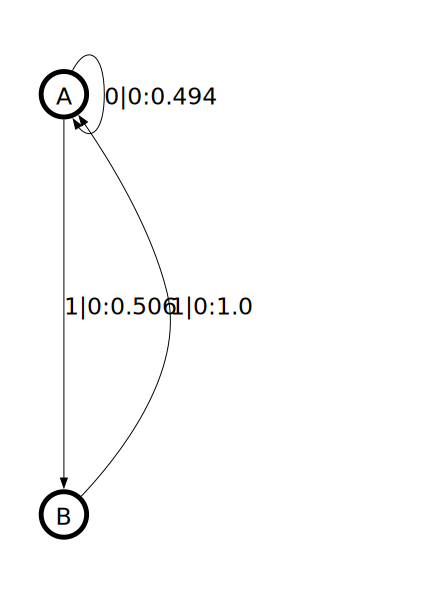

In [8]:
graphviz.Source.from_file('transCSSR_results/+{}.dot'.format("output_process"))

## Distance between uHMMs

If take a longer sequence of $x_1, x_2, \dots, x_N$ does it yield a better approximation, i.e. does $d (\theta, \hat{\theta}_n)$ shrinks as $N$ grows, for some distance function $d: \Theta \times \Theta \to [0, \infty]$? Which function $d$ shall we employ? We could embed conditional probabilities in RKHS (Brodu & Crutchfield[5]) and use metric implied by this Hilbert space. However, since we are dealing with discrete setting as of now, let's try to devise something simpler.

If our inference algorithm yielded different topology than the generator, i.e. either different number of hidden states $|\hat{\mathcal{S}}_N| \neq |\mathcal{S}|$ or different labeling of the edges $\hat{\delta}_N \neq \delta$ then we assume that the inference procedure has failed, i.e. $d (\theta, \hat{\theta}_n) = \infty$. Thus, calculating the distance boils down to the comparison of conditional probability measures (notice that for each hidden state we have a separate probability measure)
$$
d (\theta, \hat{\theta}_n) = \sum_{i=1}^{|\mathcal{S}|} d (p(\cdot | s_i), \hat{p}_n (\cdot | s_i))
$$

Natural candidates are *Jensen-Shannon distance* or *total variation*. The Jensen-Shannon distance is defined as the square root of the Jensen-Shannon divergence:

$$
d_{JS}(p, \hat{p}) = \sqrt{JSD(p \| \hat{p})} = \sqrt{\frac{1}{2} D_{KL}(p \| m) + \frac{1}{2} D_{KL}(\hat{p} \| m)}
$$

where $m = \frac{1}{2}(p + \hat{p})$ is the mixture distribution and $D_{KL}$ is the Kullback-Leibler divergence. The Jensen-Shannon distance is a true metric (satisfies triangle inequality) and is bounded: $0 \leq d_{JS}(p, \hat{p}) \leq \sqrt{\log 2}$.

Total variation distance is defined as:

$$
d_{TV}(p, \hat{p}) = \frac{1}{2} \sum_{x \in \mathcal{X}} |p(x) - \hat{p}(x)|
$$

In [9]:
def jensen_shannon_distance(p_true, p_hat, symbols, smoothing=1e-10):
    """
    Args:
        p_true: True probability distribution (dict or list)
        p_hat: Estimated probability distribution (dict or list)
        symbols: List of symbols in the alphabet
        smoothing: Small value to add to probabilities to avoid log(0) (default: 1e-10)
    """
    # Compute mixture distribution m = (p + q) / 2
    m = {}
    for x in symbols:
        p_x = p_true[x] if isinstance(p_true, dict) else p_true[symbols.index(x)]
        p_hat_x = p_hat[x] if isinstance(p_hat, dict) else p_hat[symbols.index(x)]
        m[x] = (p_x + p_hat_x) / 2.0
    
    # Compute KL(p || m) and KL(q || m)
    kl_p_m = 0.0
    kl_q_m = 0.0
    
    for x in symbols:
        p_x = p_true[x] if isinstance(p_true, dict) else p_true[symbols.index(x)]
        p_hat_x = p_hat[x] if isinstance(p_hat, dict) else p_hat[symbols.index(x)]
        m_x = max(m[x], smoothing)  # Add smoothing to avoid division by zero
        
        if p_x > 0:
            kl_p_m += p_x * np.log(p_x / m_x)
        if p_hat_x > 0:
            kl_q_m += p_hat_x * np.log(p_hat_x / m_x)
    
    # Jensen-Shannon divergence
    jsd = 0.5 * kl_p_m + 0.5 * kl_q_m
    
    # Jensen-Shannon distance (square root of divergence)
    return np.sqrt(jsd)


def total_variation(p_true, p_hat, symbols):
    """
    Args:
        p_true: True probability distribution (dict or list)
        p_hat: Estimated probability distribution (dict or list)
        symbols: List of symbols in the alphabet
    """
    tv = 0.0
    for x in symbols:
        p_x = p_true[x] if isinstance(p_true, dict) else p_true[symbols.index(x)]
        p_hat_x = p_hat[x] if isinstance(p_hat, dict) else p_hat[symbols.index(x)]
        tv += abs(p_x - p_hat_x)
    
    return 0.5 * tv

In [10]:
def epsilon_machine_distance(generator, morph_by_state, symbols, metric='js'):
    """
    Args:
        generator: Generator object with states and p_emission attributes
        morph_by_state: Dictionary from transCSSR output mapping states to emission counts. Format: {state_id: [count_0, count_1, ...]}
        symbols: List of symbols in the alphabet (e.g., ['0', '1'])
        metric: Distance metric to use ('js' for Jensen-Shannon distance, 'tv' for total variation)
    """
    # Check if topology matches
    if len(generator.states) != len(morph_by_state):
        return np.inf
    
    distance_func = jensen_shannon_distance if metric == 'js' else total_variation
    
    # Convert morph_by_state counts to probabilities
    inferred_states = {}
    for state_key, counts in morph_by_state.items():
        total_count = sum(counts)
        if total_count > 0:
            probs = [count / total_count for count in counts]
        else:
            probs = [0.0] * len(counts)
        inferred_states[state_key] = {symbols[i]: probs[i] for i in range(len(symbols))}
    
    # Find best state alignment using greedy matching
    true_states_probs = []
    for i, state in enumerate(generator.states):
        p_true = {symbols[j]: generator.p_emission[i][j] for j in range(len(symbols))}
        true_states_probs.append(p_true)
    
    # Match inferred states to true states
    used_inferred = set()
    total_distance = 0.0
    
    for i, p_true in enumerate(true_states_probs):
        # Find best matching inferred state
        best_dist = np.inf
        best_state = None
        
        for state_key, p_hat in inferred_states.items():
            if state_key not in used_inferred:
                # Use TV for matching (more stable than JS)
                dist = total_variation(p_true, p_hat, symbols)
                if dist < best_dist:
                    best_dist = dist
                    best_state = state_key
        
        if best_state is None:
            return np.inf
        
        used_inferred.add(best_state)
        
        # Calculate distance using specified metric
        state_distance = distance_func(p_true, inferred_states[best_state], symbols)
        
        if np.isinf(state_distance):
            return np.inf
        
        total_distance += state_distance
    
    return total_distance

In [11]:
dist_js = epsilon_machine_distance(generator, morph_by_state, generator.symbols, metric='js')
print(f"Jensen-Shannon distance: {dist_js}")

dist_tv = epsilon_machine_distance(generator, morph_by_state, generator.symbols, metric='tv')
print(f"Total variation distance: {dist_tv}")

Jensen-Shannon distance: 0.8367675252282932
Total variation distance: 1.0059578368469295


### Frobenius distance

Both, JSD and TV, take into account only $\widehat{p}$ vs $p$, while ignoring $\widehat{\mathcal{S}}$ vs $\mathcal{S}$ and $\widehat{\delta}$ vs $\delta$. Notice that both, emission probabilities $p$ and transition mappings $\delta$, are captured by the set of labeled matrices $\mathcal{T}^{(x)}$. If we assume that we correctly estimated $|\mathcal{S}|$, but we worry about correct identification of transitions between hidden states, we could solve it by calculating distance $\widehat{\mathcal{T}}$ vs $\mathcal{T}$. A natural choice is the Frobenius distance:
$$
d_F (\mathcal{T}, \widehat{\mathcal{T}}) = \sum_{x \in \mathcal{X}} \left\| \mathcal{T}^{(x)} - \widehat{\mathcal{T}}^{(x)} \right\|_F = \sum_{x \in \mathcal{X}} \sqrt{\sum_{i=1}^{|S|} \sum_{j=1}^{|S|} \left| \mathcal{T}_{ij}^{(x)} - \widehat{\mathcal{T}}_{ij}^{(x)} \right|^2}
$$

In [12]:
def frobenius_distance(generator, morph_by_state, symbols, state_alignment=None):
    """
    Args:
        generator: Generator object with states, symbols, p_emission attributes and transition structure (must define T^(x) matrices)
        morph_by_state: Dictionary from transCSSR output mapping states to emission counts
        symbols: List of symbols in the alphabet (e.g., ['0', '1'])
        state_alignment: Optional pre-computed state alignment dict {true_state_idx: inferred_state_key}
    """
    n_states = len(generator.states)
    n_symbols = len(symbols)
    
    # Check if topology matches
    if n_states != len(morph_by_state):
        return np.inf
    
    # Build true transition matrices T^(x) from generator
    # For EvenProcess: T^(x)_ij = P(S_{t+1}=j, X=x | S_t=i)
    T_true = {}
    for x_idx, x in enumerate(symbols):
        T_true[x] = np.zeros((n_states, n_states))
    
    # For EvenProcess specifically:
    # State A (index 0): emits 0 -> stays A, emits 1 -> goes to B
    # State B (index 1): emits 1 -> goes to A (only emission)
    for i, state in enumerate(generator.states):
        for x_idx, x in enumerate(symbols):
            p_emit = generator.p_emission[i][x_idx]
            if p_emit > 0:
                # Determine next state based on unifilarity
                if state == "A":
                    next_state = "A" if x == "0" else "B"
                elif state == "B":
                    next_state = "A"  # B always transitions to A (only emits 1)
                else:
                    # Generic case - need transition function
                    continue
                j = generator.states.index(next_state)
                T_true[x][i, j] = p_emit
    
    # Convert morph_by_state counts to probabilities
    inferred_probs = {}
    for state_key, counts in morph_by_state.items():
        total_count = sum(counts)
        if total_count > 0:
            probs = [count / total_count for count in counts]
        else:
            probs = [0.0] * len(counts)
        inferred_probs[state_key] = {symbols[i]: probs[i] for i in range(len(symbols))}
    
    # Find state alignment if not provided (using greedy matching based on TV)
    if state_alignment is None:
        true_states_probs = []
        for i, state in enumerate(generator.states):
            p_true = {symbols[j]: generator.p_emission[i][j] for j in range(n_symbols)}
            true_states_probs.append(p_true)
        
        state_alignment = {}
        used_inferred = set()
        
        for i, p_true in enumerate(true_states_probs):
            best_dist = np.inf
            best_state = None
            
            for state_key, p_hat in inferred_probs.items():
                if state_key not in used_inferred:
                    dist = total_variation(p_true, p_hat, symbols)
                    if dist < best_dist:
                        best_dist = dist
                        best_state = state_key
            
            if best_state is None:
                return np.inf
            
            state_alignment[i] = best_state
            used_inferred.add(best_state)
    
    # Build inferred transition matrices T_hat^(x)
    # For unifilar machines, we need to infer transitions from the structure
    # Since we don't have explicit transition info, we assume same structure as true and only the emission probabilities differ
    T_hat = {}
    for x in symbols:
        T_hat[x] = np.zeros((n_states, n_states))
    
    for i, state in enumerate(generator.states):
        inferred_key = state_alignment[i]
        for x_idx, x in enumerate(symbols):
            p_emit_hat = inferred_probs[inferred_key][x]
            if p_emit_hat > 0 or generator.p_emission[i][x_idx] > 0:
                # Use same transition structure as true machine
                if state == "A":
                    next_state = "A" if x == "0" else "B"
                elif state == "B":
                    next_state = "A"
                else:
                    continue
                j = generator.states.index(next_state)
                T_hat[x][i, j] = p_emit_hat
    
    # Calculate Frobenius distance: sum over symbols of ||T^(x) - T_hat^(x)||_F
    total_frob_dist = 0.0
    for x in symbols:
        diff = T_true[x] - T_hat[x]
        frob_norm = np.sqrt(np.sum(diff ** 2))
        total_frob_dist += frob_norm
    
    return total_frob_dist

In [13]:
dist_frob = frobenius_distance(generator, morph_by_state, generator.symbols)
print(f"Frobenius distance: {dist_frob}")

Frobenius distance: 2.0000354955049118


### Distance as $N$ grows

In [14]:
# Sequence lengths to test
N_values = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]

# Different L_max values to compare
L_max_values = [3, 5, 7]

# Generate sequence
stringY = generator.generate(n=max(N_values), seed=2137)
stringX = '0' * len(stringY)
    
ays = list(set(stringY))
axs = list(set(stringX))
e_symbols = list(itertools.product(axs, ays))

# Storage for results - separate for each L_max
results = {}
for L_max in L_max_values:
    results[L_max] = {
        'js_distances': [],
        'tv_distances': [],
        'frob_distances': [],
        'successful_N': []
    }

# Run experiments for each L_max value
for L_max in L_max_values:
    print(f"\n{'='*60}")
    print(f"Testing with L_max = {L_max}")
    print(f"{'='*60}")
    
    for N in N_values:
        try:
            # Infer uHMM
            word_lookup_marg, word_lookup_fut = estimate_predictive_distributions(
                stringX[:N], stringY[:N], L_max
            )
            
            epsilon_N, invepsilon_N, morph_by_state_N = run_transCSSR(
                word_lookup_marg,
                word_lookup_fut,
                L_max,
                axs,
                ays,
                e_symbols,
                Xt_name="",
                Yt_name="output_process",
                alpha=0.001
            )
            
            # Calculate distances
            js_dist = epsilon_machine_distance(generator, morph_by_state_N, generator.symbols, metric='js')
            tv_dist = epsilon_machine_distance(generator, morph_by_state_N, generator.symbols, metric='tv')
            frob_dist = frobenius_distance(generator, morph_by_state_N, generator.symbols)
            
            # Only record if topology matches (finite distance)
            if np.isfinite(js_dist) and np.isfinite(tv_dist) and np.isfinite(frob_dist):
                results[L_max]['successful_N'].append(N)
                results[L_max]['js_distances'].append(js_dist)
                results[L_max]['tv_distances'].append(tv_dist)
                results[L_max]['frob_distances'].append(frob_dist)
                print(f"  ✓ N={N}: JS={js_dist:.6f}, TV={tv_dist:.6f}, Frob={frob_dist:.6f}")
            else:
                print(f"  ✗ N={N}: Topology mismatch (JS={js_dist}, TV={tv_dist}, Frob={frob_dist})")
        
        except Exception as e:
            print(f"  ✗ N={N}: Error - {str(e)}")


Testing with L_max = 3
  ✗ N=100: Topology mismatch (JS=inf, TV=inf, Frob=inf)
  ✗ N=200: Topology mismatch (JS=inf, TV=inf, Frob=inf)
  ✓ N=500: JS=0.845713, TV=1.018605, Frob=2.000346
  ✓ N=1000: JS=0.833795, TV=1.001754, Frob=2.000003
  ✓ N=2000: JS=0.835878, TV=1.004700, Frob=2.000022
  ✓ N=5000: JS=0.836025, TV=1.004908, Frob=2.000024
  ✓ N=10000: JS=0.833105, TV=1.000778, Frob=2.000001
  ✓ N=20000: JS=0.834655, TV=1.002971, Frob=2.000009
  ✓ N=50000: JS=0.833490, TV=1.001323, Frob=2.000002
  ✓ N=100000: JS=0.834796, TV=1.003170, Frob=2.000010

Testing with L_max = 5
  ✗ N=100: Topology mismatch (JS=inf, TV=inf, Frob=inf)
  ✗ N=200: Topology mismatch (JS=inf, TV=inf, Frob=inf)
  ✓ N=500: JS=0.834445, TV=1.002674, Frob=2.000007
  ✓ N=1000: JS=0.833509, TV=1.001350, Frob=2.000002
  ✓ N=2000: JS=0.833671, TV=1.001579, Frob=2.000002
  ✓ N=5000: JS=0.834569, TV=1.002849, Frob=2.000008
  ✓ N=10000: JS=0.833662, TV=1.001567, Frob=2.000002
  ✓ N=20000: JS=0.834157, TV=1.002266, Frob=2.00

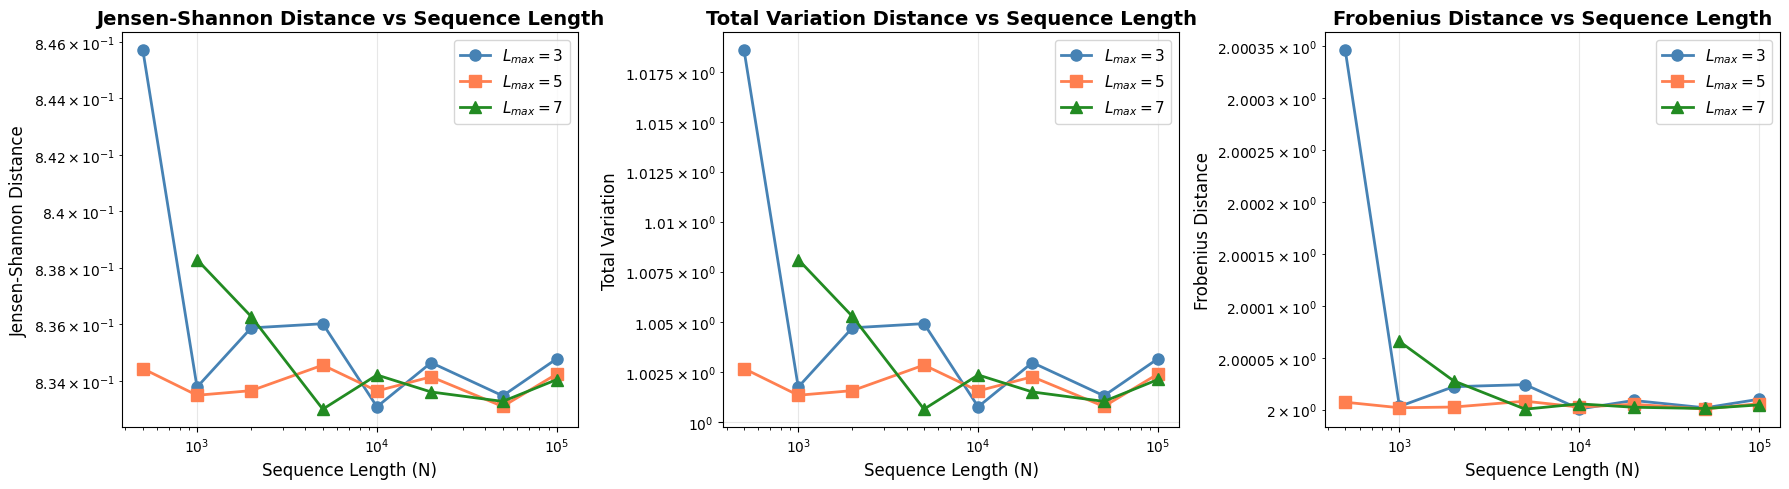

In [15]:
# Create plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Color and marker styles for different L_max values
colors = ['steelblue', 'coral', 'forestgreen']
markers = ['o', 's', '^']

# Jensen-Shannon distance plot
for i, L_max in enumerate(L_max_values):
    if results[L_max]['successful_N']:
        ax1.plot(results[L_max]['successful_N'], 
                results[L_max]['js_distances'], 
                marker=markers[i], 
                linewidth=2, 
                markersize=8, 
                color=colors[i],
                label=f'$L_{{max}}={L_max}$')

ax1.set_xlabel('Sequence Length (N)', fontsize=12)
ax1.set_ylabel('Jensen-Shannon Distance', fontsize=12)
ax1.set_title('Jensen-Shannon Distance vs Sequence Length', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(fontsize=11, loc='best')

# Total Variation plot
for i, L_max in enumerate(L_max_values):
    if results[L_max]['successful_N']:
        ax2.plot(results[L_max]['successful_N'], 
                results[L_max]['tv_distances'], 
                marker=markers[i], 
                linewidth=2, 
                markersize=8, 
                color=colors[i],
                label=f'$L_{{max}}={L_max}$')

ax2.set_xlabel('Sequence Length (N)', fontsize=12)
ax2.set_ylabel('Total Variation', fontsize=12)
ax2.set_title('Total Variation Distance vs Sequence Length', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(fontsize=11, loc='best')

# Frobenius distance plot
for i, L_max in enumerate(L_max_values):
    if results[L_max]['successful_N']:
        ax3.plot(results[L_max]['successful_N'], 
                results[L_max]['frob_distances'], 
                marker=markers[i], 
                linewidth=2, 
                markersize=8, 
                color=colors[i],
                label=f'$L_{{max}}={L_max}$')

ax3.set_xlabel('Sequence Length (N)', fontsize=12)
ax3.set_ylabel('Frobenius Distance', fontsize=12)
ax3.set_title('Frobenius Distance vs Sequence Length', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend(fontsize=11, loc='best')

plt.tight_layout()
plt.show()

## References

1. Travers, N. F. Exponential Bounds for Convergence of Entropy Rate Approximations in Hidden Markov Models Satisfying a Path-Mergeability Condition. Preprint at https://doi.org/10.48550/arXiv.1211.6181 (2014).

2. Shalizi, C. R. & Shalizi, K. L. Blind Construction of Optimal Nonlinear Recursive Predictors for Discrete Sequences. Preprint at https://doi.org/10.48550/arXiv.cs/0406011 (2004).

3. https://github.com/ddarmon/transCSSR

4. Barnett, N. & Crutchfield, J. P. Computational Mechanics of Input-Output Processes: Structured transformations and the $ε$-transducer. J Stat Phys 161, 404–451 (2015).

5. Brodu, N. & Crutchfield, J. P. Discovering causal structure with reproducing-kernel Hilbert space  ε  -machines. Chaos: An Interdisciplinary Journal of Nonlinear Science 32, 023103 (2022).


## To be added:
 - State alignment currently is done via greedy matching based on total variation. This works for 2 states but may not find the optimal matching for larger machines. To be replaced with the Hungarian algorithm.
 - Experiment runs only one realization with a fixed seed. To properly assess convergence we will run multiple independent sequences and then calcualte confidence intervals.
 - Add a function that validates the unifilarity structure.